# Toyota Corolla — Multiple Linear Regression

In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
RANDOM_STATE = 42



## 2) Load the data


In [21]:

df = pd.read_csv('ToyotaCorolla - MLR.csv')
print('Shape:', df.shape)
df.head()


Shape: (1436, 11)


,Price,Age_08_04,KM,Fuel_Type,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
0,13500,23,46986,Diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,Diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,Diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,Diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,Diesel,90,0,2000,3,4,5,1170


## 3) Simple EDA

Check types, missing values and summary statistics.

In [36]:

print(df.dtypes)
print('\nMissing values per column:\n', df.isna().sum())
df.describe()




Price         int64
Age_08_04     int64
KM            int64
Fuel_Type    object
HP            int64
Automatic     int64
cc            int64
Doors         int64
Cylinders     int64
Gears         int64
Weight        int64
dtype: object

Missing values per column:
 Price        0
Age_08_04    0
KM           0
Fuel_Type    0
HP           0
Automatic    0
cc           0
Doors        0
Cylinders    0
Gears        0
Weight       0
dtype: int64


,Price,Age_08_04,KM,HP,Automatic,cc,Doors,Cylinders,Gears,Weight
count,"1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000","1,436.0000"
mean,"10,730.8245",55.9471,"68,533.2597",101.5021,0.0557,"1,576.8558",4.0334,4.0000,5.0265,"1,072.4596"
std,"3,626.9646",18.6000,"37,506.4489",14.9811,0.2294,424.3868,0.9527,0.0000,0.1885,52.6411
min,"4,350.0000",1.0000,1.0000,69.0000,0.0000,"1,300.0000",2.0000,4.0000,3.0000,"1,000.0000"
25%,"8,450.0000",44.0000,"43,000.0000",90.0000,0.0000,"1,400.0000",3.0000,4.0000,5.0000,"1,040.0000"
50%,"9,900.0000",61.0000,"63,389.5000",110.0000,0.0000,"1,600.0000",4.0000,4.0000,5.0000,"1,070.0000"
75%,"11,950.0000",70.0000,"87,020.7500",110.0000,0.0000,"1,600.0000",5.0000,4.0000,5.0000,"1,085.0000"
max,"32,500.0000",80.0000,"243,000.0000",192.0000,1.0000,"16,000.0000",5.0000,4.0000,6.0000,"1,615.0000"


### Histograms for numeric columns

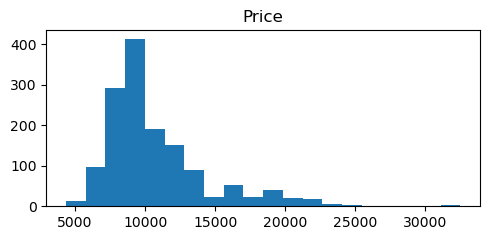

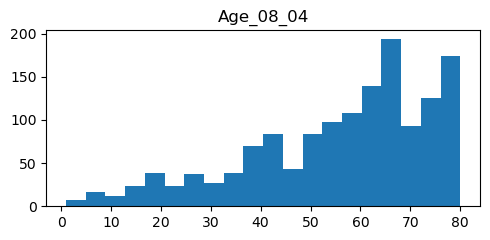

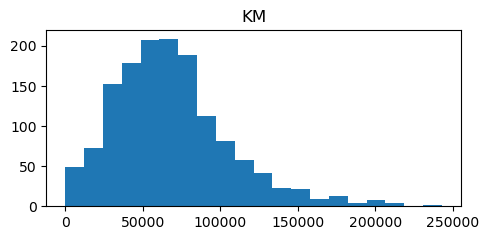

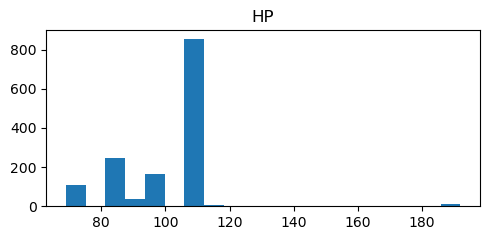

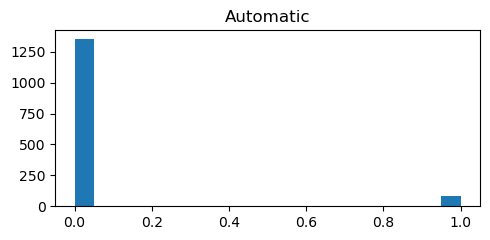

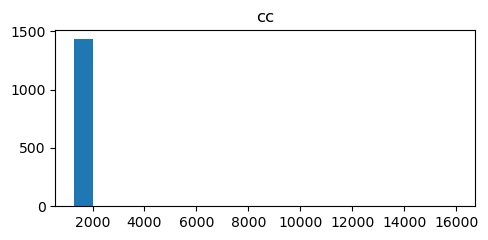

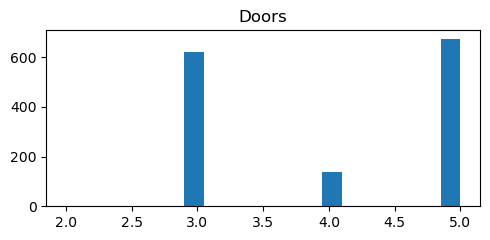

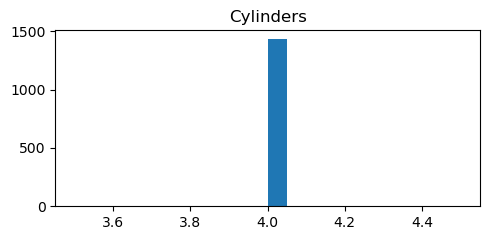

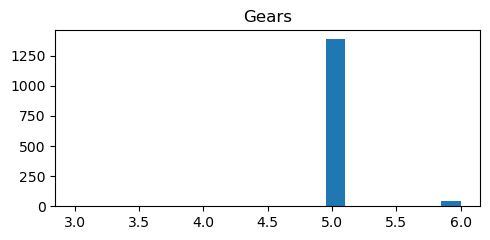

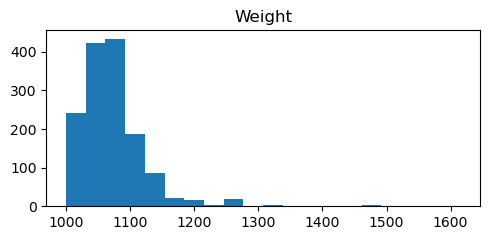

In [23]:

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    plt.figure(figsize=(5,2.5))
    plt.hist(df[col].dropna(), bins=20)
    plt.title(col)
    plt.tight_layout()
    plt.show()


## 4) Preprocessing

One-hot encode Fuel_Type and prepare X and y.

In [24]:

df_prep = df.copy()
if 'Fuel_Type' in df_prep.columns:
    df_prep = pd.get_dummies(df_prep, columns=['Fuel_Type'], drop_first=True)

target = 'Price'
y = df_prep[target]
X = df_prep.drop(columns=[target])

# Drop constant columns
constant_cols = [c for c in X.columns if X[c].nunique() <= 1]
if constant_cols:
    X = X.drop(columns=constant_cols)
    print('Dropped constant columns:', constant_cols)

print('Features:', X.columns.tolist())


Dropped constant columns: ['Cylinders']
Features: ['Age_08_04', 'KM', 'HP', 'Automatic', 'cc', 'Doors', 'Gears', 'Weight', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol']


## 5) Train/Test split (80/20)

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)


Train shape: (1148, 10) Test shape: (288, 10)


In [26]:

def rmse(y_true, y_pred): return mean_squared_error(y_true, y_pred, squared=False)

def evaluate(name, model, Xtr, ytr, Xte, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    return {
        'Model': name,
        'R2_train': r2_score(ytr, ytr_pred),
        'R2_test': r2_score(yte, yte_pred),
        'RMSE_train': rmse(ytr, ytr_pred),
        'RMSE_test': rmse(yte, yte_pred),
        'MAE_test': mean_absolute_error(yte, yte_pred)
    }

def compute_vif(df_features):
    X_const = sm.add_constant(df_features)
    vifs = pd.Series([variance_inflation_factor(X_const.values, i+1) for i in range(len(df_features.columns))],
                     index=df_features.columns)
    return vifs


## 6) Model 1 — All features

Fit a Linear Regression with all features.

In [27]:

model1 = LinearRegression()
model1.fit(X_train, y_train)
coefs = pd.Series(model1.coef_, index=X_train.columns)
print('Intercept:', model1.intercept_)
display(coefs.sort_values(ascending=False))
m1_metrics = evaluate('Model 1 - All features', model1, X_train, y_train, X_test, y_test)
m1_metrics


Intercept: -14255.385993565298


Fuel_Type_Petrol   1,370.8089
Gears                551.6007
Automatic            148.8309
Weight                25.8850
HP                    14.0395
KM                    -0.0162
cc                    -0.0304
Doors                -60.3110
Fuel_Type_Diesel     -68.5488
Age_08_04           -120.8305
dtype: float64

c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'Model': 'Model 1 - All features',
 'R2_train': 0.8702643169608926,
 'R2_test': 0.8348888040611082,
 'RMSE_train': 1303.3396224118353,
 'RMSE_test': 1484.265415329652,
 'MAE_test': 990.8872739193931}

## 7) Model 2 — Diagnostics to identify weak features

We compute standardized betas, p-values, and VIF. Then flag features meeting at least two weak conditions.

In [28]:

# Standardized betas
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.values.reshape(-1,1))
X_train_std = scaler_X.transform(X_train)
y_train_std = scaler_y.transform(y_train.values.reshape(-1,1)).ravel()
lr_std = LinearRegression().fit(X_train_std, y_train_std)
std_betas = pd.Series(lr_std.coef_, index=X_train.columns)
std_betas_abs = std_betas.abs()

# p-values (safe numeric conversion for statsmodels)
# Force all features to numeric (coerce errors to NaN)
X_train_num = X_train.apply(pd.to_numeric, errors='coerce')
X_train_num = X_train_num.fillna(0)   # replace NaN with 0 (or you can drop columns if you prefer)

# Add constant for intercept
X_train_sm = sm.add_constant(X_train_num)

# Also ensure y is numeric
y_train_num = pd.to_numeric(y_train, errors='coerce')

# Fit OLS safely
ols = sm.OLS(y_train_num, X_train_sm.astype(float)).fit()

# Extract p-values
p_values = ols.pvalues.drop('const')

print(ols.summary())  # optional



# VIF
def compute_vif(df_features):
    # Keep only numeric columns (avoid errors with categorical/object types)
    df_num = df_features.select_dtypes(include=[np.number])
    
    X_sm = sm.add_constant(df_num)
    vifs = pd.Series(
        [variance_inflation_factor(X_sm.values, i) for i in range(X_sm.shape[1])],
        index=X_sm.columns
    )
    return vifs.drop("const")




                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     762.7
Date:                Sun, 31 Aug 2025   Prob (F-statistic):               0.00
Time:                        18:48:05   Log-Likelihood:                -9863.2
No. Observations:                1148   AIC:                         1.975e+04
Df Residuals:                    1137   BIC:                         1.980e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -1.426e+04   1751.390  

## 8) Model 3 — Remove weak features and refit

We drop the weak features from X and fit a new linear model.

In [33]:

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def evaluate_model(model, Xtr, ytr, Xte, yte, name=''):
    """Return R^2, RMSE, MAE for train/test."""
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    out = {
        'Model': name,
        'R2_train': r2_score(ytr, ytr_pred),
        'R2_test': r2_score(yte, yte_pred),
        'RMSE_train': mean_squared_error(ytr, ytr_pred, squared=False),
        'RMSE_test': mean_squared_error(yte, yte_pred, squared=False),
        'MAE_test': mean_absolute_error(yte, yte_pred)
    }
    return out
# Ensure weak_features exists (if Model 2 flagged nothing, keep all features)
try:
    weak_features
except NameError:
    weak_features = []

X_train_m3 = X_train.drop(columns=weak_features, errors='ignore')
X_test_m3  = X_test.drop(columns=weak_features, errors='ignore')

model3 = LinearRegression().fit(X_train_m3, y_train)
m3_metrics = evaluate_model(model3, X_train_m3, y_train, X_test_m3, y_test, name='Model 3 — After Removing Weak Features')


print("Removed weak features:", weak_features)
pd.DataFrame([m3_metrics])



Removed weak features: []


c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Model,R2_train,R2_test,RMSE_train,RMSE_test,MAE_test
0,Model 3 — After Removing Weak Features,0.8703,0.8349,"1,303.3396","1,484.2654",990.8873


## 9) Simple plots: Actual vs Predicted on Test set

Compare Model 1 and Model 3 visually.

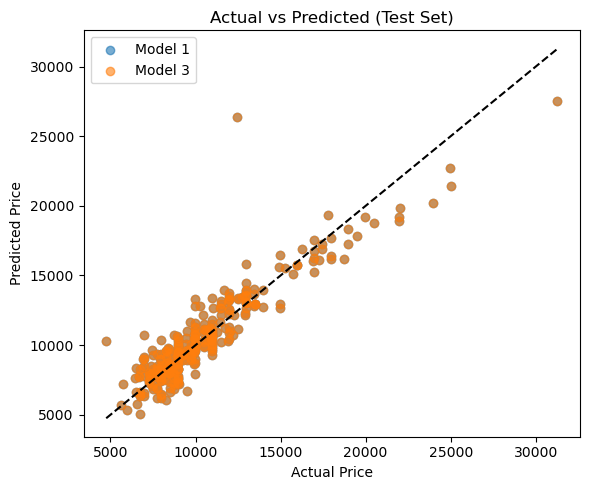

In [34]:

y_pred_m3 = m3.predict(X_test_m3)

y_pred_m3 = model3.predict(X_test_m3)

plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_m1, alpha=0.6, label='Model 1')
plt.scatter(y_test, y_pred_m3, alpha=0.6, label='Model 3')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.title('Actual vs Predicted (Test Set)')
plt.tight_layout()
plt.show()


## 10) Lasso & Ridge (simple)

Fit LassoCV and RidgeCV with scaling and compare test performance.

In [31]:

alphas = np.logspace(-3,3,30)
ridge_pipe = Pipeline([('scale', StandardScaler()), ('ridge', RidgeCV(alphas=alphas, cv=5))])
lasso_pipe = Pipeline([('scale', StandardScaler()), ('lasso', LassoCV(cv=5, max_iter=10000))])

ridge_pipe.fit(X_train, y_train)
lasso_pipe.fit(X_train, y_train)

ridge_info = evaluate('Ridge', ridge_pipe, X_train, y_train, X_test, y_test)
ridge_info['alpha'] = ridge_pipe.named_steps['ridge'].alpha_
lasso_info = evaluate('Lasso', lasso_pipe, X_train, y_train, X_test, y_test)
lasso_info['alpha'] = lasso_pipe.named_steps['lasso'].alpha_

pd.DataFrame([ridge_info, lasso_info]).set_index('Model')


c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\rajku\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

,R2_train,R2_test,RMSE_train,RMSE_test,MAE_test,alpha
Model,,,,,,
Ridge,0.8671,0.8416,"1,319.2821","1,453.8056",993.0481,92.3671
Lasso,0.8689,0.8424,"1,310.2572","1,450.1089",994.2807,48.2986


## Interview Questions
### 1. What is Normalization & Standardization?
- **Normalization**: Scales values between 0 and 1. Useful when features have very different ranges.
- **Standardization**: Converts data to have mean 0 and standard deviation 1. Useful when applying linear models.

### 2.What techniques can be used to address multicollinearity in multiple linear regression?
- Remove highly correlated features.
- Use **Variance Inflation Factor (VIF)** to detect multicollinearity.
- Apply **Regularization (Ridge/Lasso)** to reduce effect of multicollinearity.
- Use **PCA (Principal Component Analysis)** if needed.
